In [3]:
import jax
import jax.numpy as jnp
import numpy as np
import os
import meshio
import matplotlib.pyplot as plt
from jax_am.common import yaml_parse
from orix import plot
from orix.quaternion import Orientation, symmetry
from orix.vector import Vector3d
from PIL import Image

Generated Euler Angles (phi1, Phi, phi2) in Degrees:
[[288.26804472  99.5527744  355.98999201]
 [348.57416726  63.85470362 269.33963558]
 [112.83270414 178.77446388 100.95983714]
 [249.23614164 113.28685973 284.14055824]
 [315.50009483 134.9499007   37.16136237]
 [322.05839886 144.61929317 161.24166942]
 [ 30.61591609 128.86441414 327.09438111]
 [ 14.05972196 107.99165946 105.70109341]
 [ 61.13895104 101.91527523 103.59912189]
 [316.13130123  85.54744972  46.81028596]
 [ 35.40486018  99.30041513   6.97210483]
 [151.598745    68.25730586 244.38079186]
 [344.84023085 126.23478684  76.18612176]
 [191.93950259  40.86661248  95.59679737]
 [249.07576102 160.94836925 176.96633734]
 [113.58562716  70.06614921  19.21051624]
 [247.14033397  99.51991407 206.68233798]
 [300.46524188  83.25910087  52.82228697]
 [  6.58377984 135.99062461 212.14999329]
 [270.05195338 127.14232608 251.91300961]]


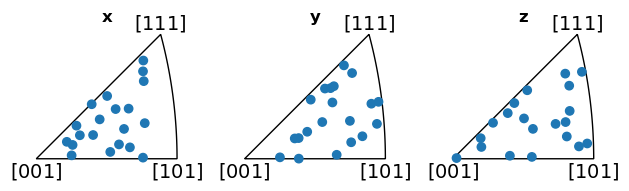

In [ ]:
def generate_uniform_orientations(num_orientations=20):
    """
    sample random oris on a sphere.
    (phi1, Phi, phi2)

    params:
        num_orientations (int): the number of oris
    
    return:
        euler_angles (numpy.ndarray): shape (num_orientations, 3)
    """
    np.random.seed(1)
    z = np.random.uniform(-1, 1, num_orientations)
    theta = np.random.uniform(0, 2 * np.pi, num_orientations)
    r = np.sqrt(1 - z**2)
    
    x = r * np.cos(theta)
    y = r * np.sin(theta)

    phi1 = np.arctan2(y, x)
    Phi = np.arccos(z)
    phi2 = np.random.uniform(0, 2 * np.pi, num_orientations)

    phi1 = np.mod(phi1, 2 * np.pi)
    phi2 = np.mod(phi2, 2 * np.pi)

    euler_angles = np.stack((phi1, Phi, phi2), axis=-1)
    return euler_angles

# 20 oris
euler_angles = generate_uniform_orientations(20)

# print results
euler_angles_degrees = np.degrees(euler_angles)
print("Generated Euler Angles (phi1, Phi, phi2) in Degrees:")
print(euler_angles_degrees)

v = Vector3d([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
kwargs = {"projection": "ipf", "direction": v}

rand_oris = Orientation.from_euler(euler_angles_degrees, symmetry.Oh, degrees=True)
rand_oris.scatter(**kwargs)

[[1.         0.3249126  0.30677569]
 [0.98691478 1.         0.04768824]
 [1.         0.0356204  0.01799147]
 [1.         0.64444517 0.8386094 ]
 [0.37214    0.44494025 1.        ]
 [0.71176575 1.         0.81318704]
 [0.06899408 0.47085629 1.        ]
 [1.         0.19375033 0.72280117]
 [1.         0.08827115 0.49416714]
 [0.11761272 1.         0.27443007]
 [1.         0.15415888 0.31063735]
 [0.77966922 0.11760828 1.        ]
 [0.511009   1.         0.78313658]
 [0.2768059  1.         0.28192282]
 [1.         0.64052499 0.07917756]
 [1.         0.11922173 0.9104745 ]
 [1.         0.90930081 0.76429771]
 [0.50569455 1.         0.52367079]
 [0.34510697 0.61313741 1.        ]
 [0.40897145 1.         0.96908419]] <class 'numpy.ndarray'> (20, 3)


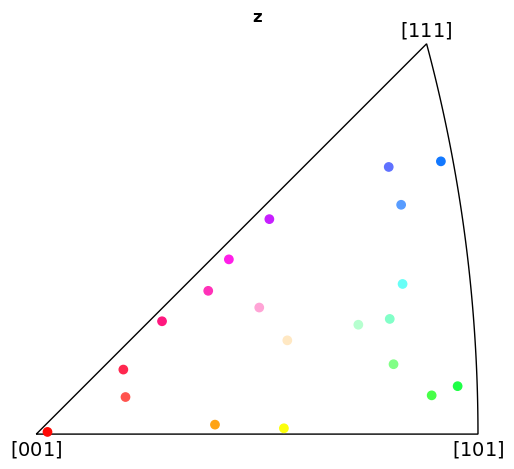

In [5]:
ipfkey = plot.IPFColorKeyTSL(symmetry.Oh)
plt.rcParams["axes.grid"] = False

directions = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]
ipfkey.direction = Vector3d(directions[2])

rgb_z = ipfkey.orientation2color(rand_oris)
np.save("rgb_z.npy", np.array(rgb_z) )
print(rgb_z, type(rgb_z), rgb_z.shape)
rand_oris.scatter("ipf", c=rgb_z, direction=ipfkey.direction)

# Denoise

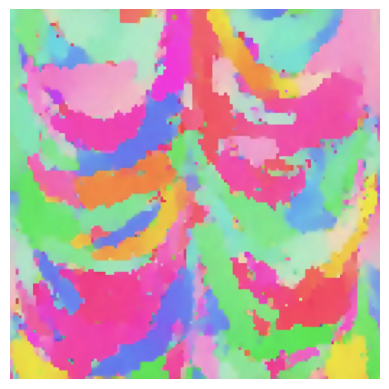

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def denoise_image(img: np.ndarray) -> np.ndarray:
    """
    further denoise the generated image. maynot be necessary.
    """
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    denoised = cv2.fastNlMeansDenoisingColored(
        img,
        None,
        h=15,           
        hColor=15,      
        templateWindowSize=7,
        searchWindowSize=21
    )
    return denoised

def main(image_path: str, output_path):
    if not os.path.exists(image_path):
        print(f"path does not exist: {image_path}")
        return

    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print(f"cannot read image: {image_path}")
        return

    # rgb
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    denoised = denoise_image(img_rgb)

    # plt.figure(figsize=(10, 5))

    # plt.subplot(1, 2, 1)
    # plt.imshow(img_rgb)
    # plt.title("original")
    # plt.axis('off')

    # plt.subplot(1, 2, 2)
    # plt.imshow(denoised)
    # plt.title("denoised")
    # plt.axis('off')

    # plt.tight_layout()
    # plt.show()

    plt.imshow(denoised)
    plt.axis('off')
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0, dpi=300)

if __name__ == "__main__":
    # change to your path
    image_path = "cross_sec/gen_images/tune/tune15-2.jpg"
    output_path ='cross_sec/gen_images/tune/tune_15-2_denoised.jpg'
    # image_path = "long_sec/gen_images/trans/trans_b111.jpg"
    # output_path ='long_sec/gen_images/trans/trans_b111_denoised.jpg'
    main(image_path, output_path)

# change the colors

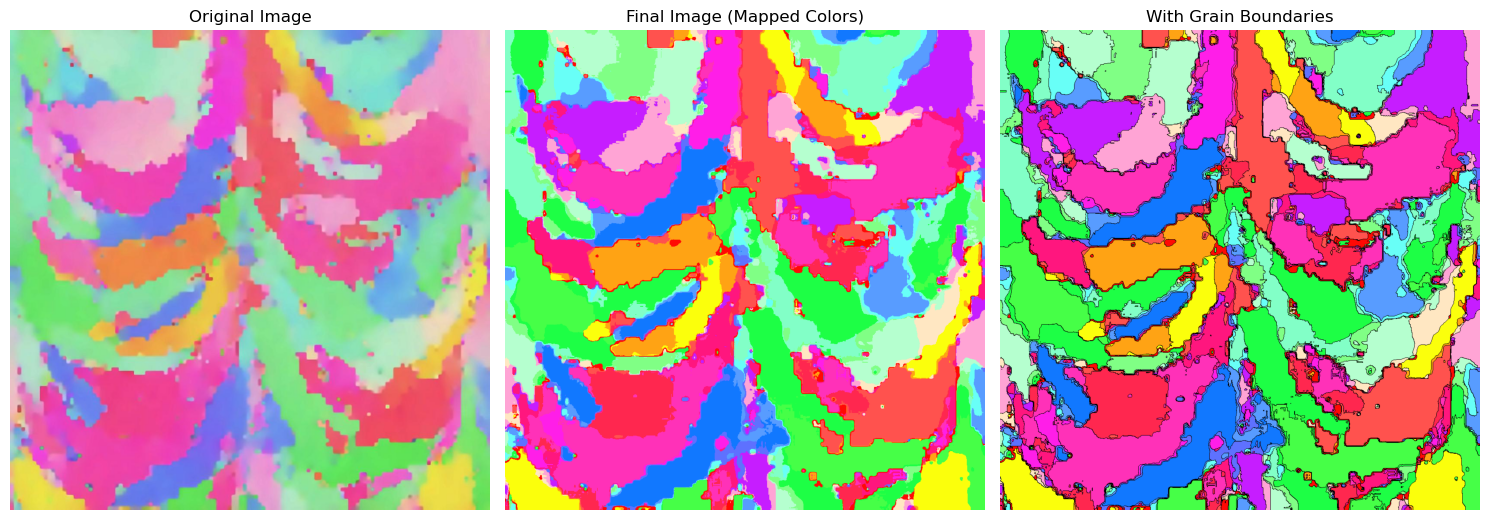

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from scipy.optimize import linear_sum_assignment


def kmeans_cluster_image(image_path, n_clusters):
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)
    h, w, c = image_np.shape
    pixels = image_np.reshape(-1, 3)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    kmeans.fit(pixels)

    labels = kmeans.labels_.reshape(h, w)
    cluster_centers = kmeans.cluster_centers_  # shape: (n_clusters, 3)

    return image_np, labels, cluster_centers


def map_centers_to_target_colors_unique(cluster_centers, target_colors):
    centers_norm = cluster_centers / 255.0
    dist_matrix = euclidean_distances(centers_norm, target_colors)

    row_ind, col_ind = linear_sum_assignment(dist_matrix)
    sorted_indices = col_ind[np.argsort(row_ind)]
    mapped_colors = target_colors[sorted_indices]

    return mapped_colors, sorted_indices


def reconstruct_image_from_labels(labels, color_mapping):
    h, w = labels.shape
    pixels = color_mapping[labels.flatten()]
    image = (pixels * 255).astype(np.uint8).reshape(h, w, 3)
    return image


def find_label_boundaries(label_image):
    """
    find the the edges of generated data.
    """
    h, w = label_image.shape
    bd_img = np.zeros_like(label_image, dtype=np.uint8)

    diff_x = label_image[:, :-1] != label_image[:, 1:]
    bd_img[:, :-1][diff_x] = 1

    diff_y = label_image[:-1, :] != label_image[1:, :]
    bd_img[:-1, :][diff_y] = 1

    return bd_img


def overlay_boundaries_on_image(rgb_image, boundary_mask, color=(0, 0, 0)):
    """
    change the color of the boundaries.
    """
    output = rgb_image.copy()
    output[boundary_mask == 1] = color
    return output


def main(image_path, target_colors, n_clusters, output_path1, output_path2, output_path3, output_path0):
    assert target_colors.shape[1] == 3, "target_colors must be shape (N, 3)"
    assert np.max(target_colors) <= 1.0, "target_colors values must be in [0, 1]"
    assert len(target_colors) >= n_clusters, "target_colors must contain at least n_clusters colors"

    image_np, labels, cluster_centers = kmeans_cluster_image(image_path, n_clusters=n_clusters)

    mapped_colors, mapped_indices = map_centers_to_target_colors_unique(cluster_centers, target_colors)

    final_image = reconstruct_image_from_labels(labels, mapped_colors)

    boundary_mask = find_label_boundaries(labels)

    overlaid_image = overlay_boundaries_on_image(final_image, boundary_mask, color=(0, 0, 0))

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image_np)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Final Image (Mapped Colors)")
    plt.imshow(final_image)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("With Grain Boundaries")
    plt.imshow(overlaid_image)
    plt.axis("off")

    plt.tight_layout()
    plt.show()
    plt.close()

    plt.imshow(final_image)
    plt.axis("off")
    plt.savefig(output_path1, bbox_inches='tight', pad_inches=0, dpi=300)
    plt.close()

    plt.imshow(overlaid_image)
    plt.axis("off")
    plt.savefig(output_path2, bbox_inches='tight', pad_inches=0, dpi=300)
    plt.close()

    np.save(output_path0, final_image)
    np.save(output_path3, overlaid_image)


if __name__ == "__main__":
    image_path = "cross_sec/gen_images/tune/tune_15-2_denoised.jpg" 
    output_path1 = "cross_sec/gen_images/tune/tune_15-2_fixed.jpg" 
    output_path0 = "cross_sec/gen_images/tune/tune_15-2_fixed.npy" 
    output_path2 = "cross_sec/gen_images/tune/tune_15-2_edge.jpg"
    output_path3 = "cross_sec/gen_images/tune/tune_15-2_edge.npy"

    n_clusters = 20
    target_colors = rgb_z

    main(image_path, target_colors, n_clusters=n_clusters, output_path1=output_path1, output_path2=output_path2, output_path3=output_path3, output_path0=output_path0)